In [2]:
import numpy as np

In [3]:
import matplotlib.pyplot as plt

In [4]:
def add_intercept(x):
    x_new = np.zeros((x.shape[0],x.shape[1]+1),dtype = x.dtype)
    x_new[:,0] = 1
    x_new[:,1:] = x
    return x_new
    

In [5]:
def load_data(csv_path,label = "y",add_intercept = False):
    def add_intercept_d(x):
        global add_intercept
        return add_intercept(x)
    with open(csv_path,'r') as f:
        header = f.readline().strip().split(",")
    x_col = [i for i in range(len(header)) if header[i].startswith("x")]
    l_col = [i for i in range(len(header)) if header[i] == label]
    inputs = np.loadtxt(csv_path,delimiter = ',', skiprows = 1, usecols = x_col)
    labels = np.loadtxt(csv_path, delimiter = ',' , skiprows = 1, usecols = l_col)
    if inputs.ndim == 1:
        inputs = np.expand_dims(inputs,-1)
    if add_intercept:
        inputs = add_intercept_d(inputs)
    return inputs,labels
        

In [6]:
def sigmod(x):
    return np.exp(np.clip(x,-500,500)) / (1 + np.exp(np.clip(x,-500,500)))
def dsigmod(x):
    return sigmod(x)*(1-sigmod(x))

In [7]:
class LinearModel(object):
    def __init__(self, max_itr = 10000, step_size = 2, eps = 1e-5, verbose = True, Theta = None):
        self.max_itr = max_itr
        self.step_size = step_size
        self.eps = eps
        self.verbose = verbose
        self.Theta = Theta
    def fit(self, x, y):
        raise NotImplementedError('Subclass of LinearModel must implement fit method.')
    def pridict(self,x,y,savecsv_path):
        raise NotImplementedError('Subclass of LinearModel must implement pridict method.')

            

In [8]:
def plot(x, y, theta, save_path, correction=1.0):
    # Plot dataset
    plt.figure()
    plt.scatter(x=x[y == 1, -2], y=x[y == 1, -1],c="green",marker=".",label="Class 1")
    plt.scatter(x=x[y == 0, -2], y=x[y == 0, -1],c="blue",marker=".",label="class 0")

    # Plot decision boundary (found by solving for theta^T x = 0)
    margin1 = (max(x[:, -2]) - min(x[:, -2]))*0.2
    margin2 = (max(x[:, -1]) - min(x[:, -1]))*0.2
    x1 = np.arange(min(x[:, -2])-margin1, max(x[:, -2])+margin1, 0.01)
    x1 = np.expand_dims(x1,1)
    a = np.zeros((x1.shape[0],x1.shape[1]+1))
    a[:,0] = 1
    a[:,1:] = x1
    x2 = -(a@theta[:-1])/theta[-1]
    plt.plot(x1, x2, c='red', linewidth=2)
    plt.xlim(x[:, -2].min()-margin1, x[:, -2].max()+margin1)
    plt.ylim(x[:, -1].min()-margin2, x[:, -1].max()+margin2)

    # Add labels and save to disk
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.legend()
    plt.savefig(save_path)

In [9]:
class mod1(LinearModel):
    def fit(self,x,y):
        m,n = x.shape
        self.Theta = np.zeros(n)
        for i in range(self.max_itr):
            tPre = self.Theta.copy()
            y_prid = sigmod(x@self.Theta)
            gradient = (1/m)*(x.T@(y_prid-y))
            self.Theta -= self.step_size*gradient
            if np.linalg.norm(self.Theta - tPre, ord = 1) < self.eps:
                print(f"Converged after {i} iteration")
                break
    def pridict(self,x,y,csv_path):
        m,n = x.shape
        n+=1
        yPrid = sigmod(x@self.Theta)
        data = np.zeros((m,n),dtype = x.dtype)
        data[:,:2]=x[:,1:]
        data[:,2] = y
        data[:,3]= yPrid
        np.savetxt(csv_path,data,delimiter = ',',fmt='%.3f',header = "x_1,x_2,y,y_prid",comments='')

In [10]:
class NLinModel(LinearModel):
    def fit(self,x,y):
        m,n = x.shape
        self.Theta = np.zeros(n)
        for i in range(self.max_itr):
            y_prid = sigmod(x@self.Theta)
            gradient = (1/m)*x.T@(y_prid-y)
            H = (1/m)*(x.T*(y_prid*(1-y_prid)))@x
            tPre = self.Theta.copy()
            self.Theta -= np.linalg.inv(H)@gradient
            if np.linalg.norm(self.Theta - tPre, ord = 1) < self.eps:
                print(f"Converged after {i} iteration")
                break
    def pridict(self,x,y,csv_path):
        m,n = x.shape
        n+=1
        yPrid = sigmod(x@self.Theta)
        data = np.zeros((m,n),dtype = x.dtype)
        data[:,:2]=x[:,1:]
        data[:,2] = y
        data[:,3]= yPrid
        np.savetxt(csv_path, data, delimiter = ',', fmt='%.3f', header = "x_1,x_2,y,y_prid", comments='')

In [11]:
x_train, y_train = load_data("pS1/ds1_train.csv", add_intercept = True)

In [12]:
x2_train,y2_train = load_data("pS1/ds2_train.csv", add_intercept = True)

In [13]:
x1v, y1v = load_data("pS1/ds1_valid.csv", add_intercept = True)
x2v, y2v = load_data("pS1/ds2_valid.csv", add_intercept = True)

In [14]:
modl = mod1()


In [15]:
modl.fit(x_train, y_train)

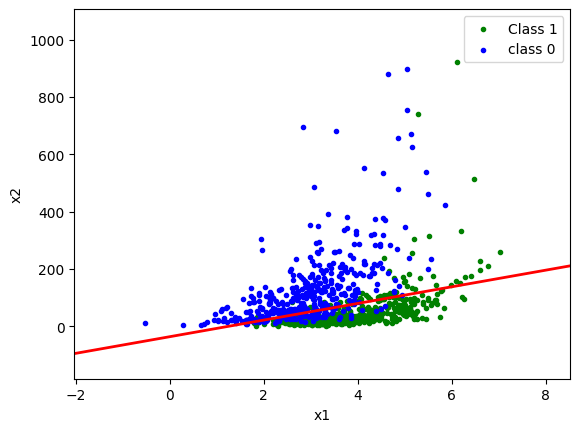

In [16]:
plot(x_train,y_train,modl.Theta,"ds1_train.png",1)

In [17]:
modl.pridict(x1v,y1v,"ds1_val_prid.csv")

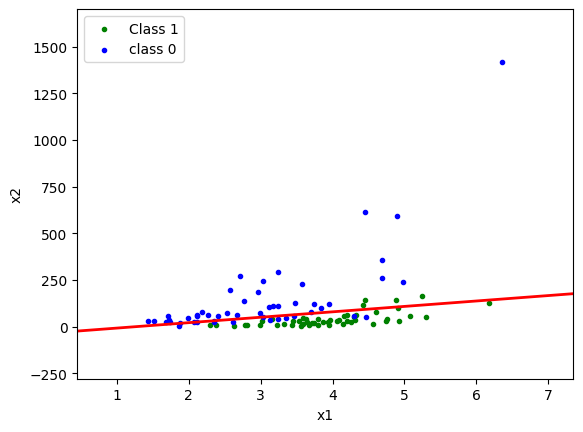

In [18]:
plot(x1v, y1v, modl.Theta, "ds1_prid1.png", 1)

In [19]:
modl.fit(x2_train, y2_train)

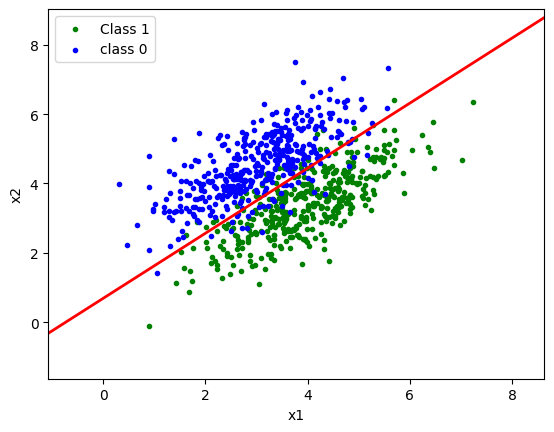

In [20]:
plot(x2_train, y2_train, modl.Theta, "ds2_train.png",1)

In [21]:
modl.pridict(x2v,y2v,"ds2_val_prid.csv")

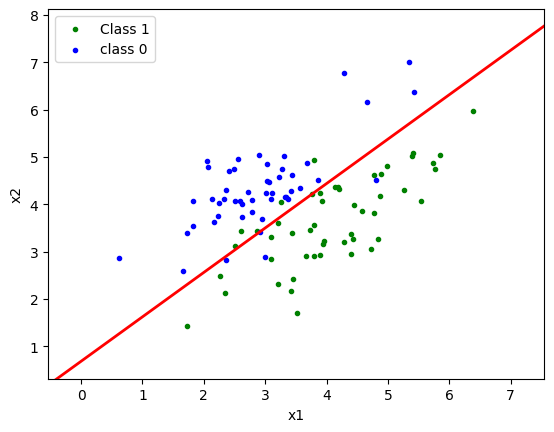

In [22]:
plot(x2v,y2v,modl.Theta,"ds2_prid1.png")

In [23]:
mod2 = NLinModel()

In [24]:
mod2.fit(x_train,y_train)

Converged after 6 iteration


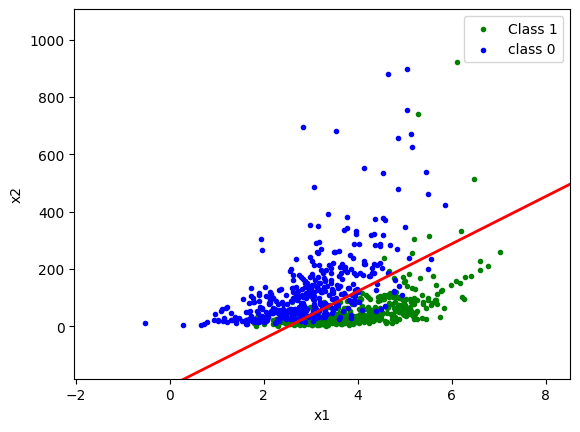

In [25]:
plot(x_train, y_train, mod2.Theta,"ds1_train_Neuton.png", 1)

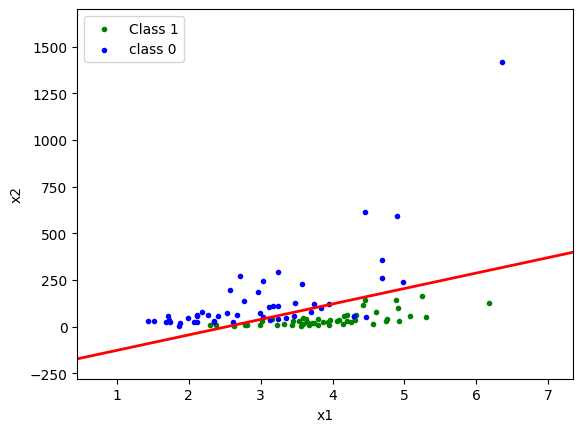

In [26]:
mod2.pridict(x1v,y1v,"ds1_val_prid_Neuton.csv")
plot(x1v,y1v,mod2.Theta,"ds1_prid_Neuton.png",1)

Converged after 7 iteration


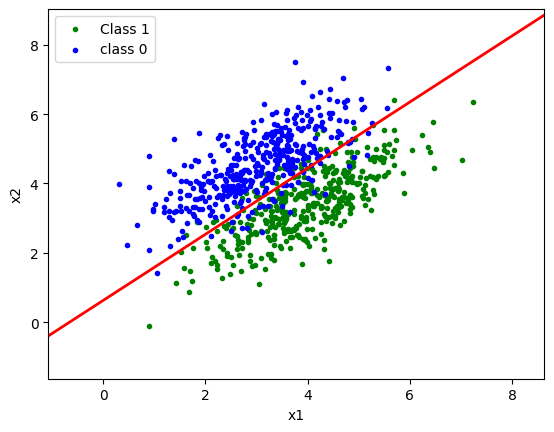

In [27]:
mod2.fit(x2_train,y2_train)
plot(x2_train, y2_train, mod2.Theta, "ds2_train_Neuton.png", 1)

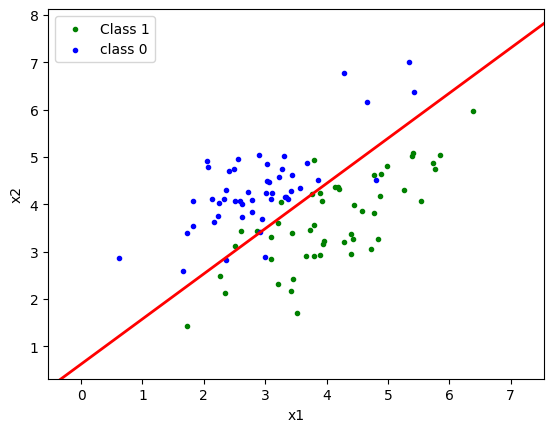

In [28]:
mod2.pridict(x2v,y2v,"ds2_val_prid_Neuton.csv")
plot(x2v,y2v,mod2.Theta,"ds2_prid_Neuton.png",1)

In [64]:
class Gda(LinearModel):
    def fit(self,x,y):
        m = y.shape[0]
        phi = y.sum()/m
        meu0 = x.T@(1-y)/m
        meu1 = x.T@y/m
        y_reshaped = np.reshape(y,(m,-1))
        mu_x = y_reshaped*meu1+(1-y_reshaped)*meu0
        delta_x = x-mu_x
        cov = delta_x.T@delta_x/m
        cov_inv = np.linalg.inv(cov)   
        self.Theta = cov_inv@(meu1-meu0)
        theta0 = (1/2)*(meu0.T@cov_inv@meu0-meu1.T@cov_inv@meu1)-np.log((1-phi)/phi)
        self.Theta[0]+=theta0
    def pridict(self,x,y,csv_path):
        m, n = x.shape
        n+=1
        yPrid = sigmod(x@self.Theta)
        data = np.zeros((m,n),dtype = x.dtype)
        data[:,:2]=x[:,1:]
        data[:,2] = y
        data[:,3]= yPrid
        np.savetxt(csv_path, data, delimiter = ',', fmt='%.3f', header = "x_1,x_2,y,y_prid", comments='')
        

In [65]:
gdaModel = Gda()


In [66]:
gdaModel.fit(x_train,y_train)

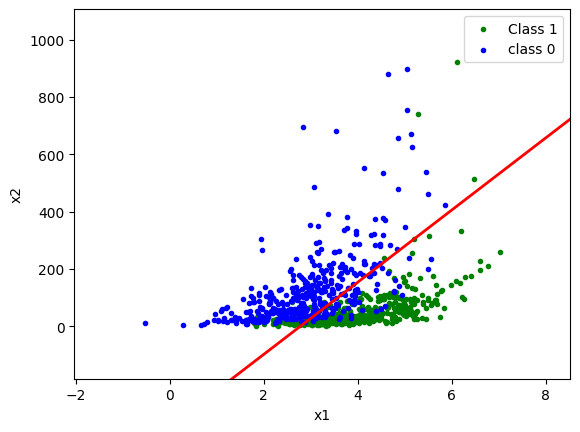

In [67]:
plot(x_train, y_train, gdaModel.Theta,"ds1_train_gda.png", 1)

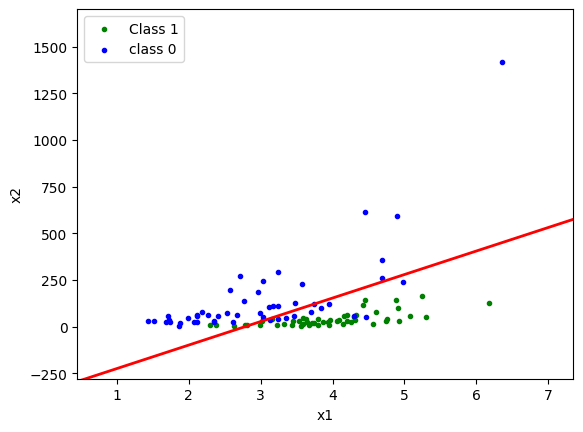

In [68]:
plot(x1v, y1v, gdaModel.Theta,"ds1_val_pri_gda.png", 1)

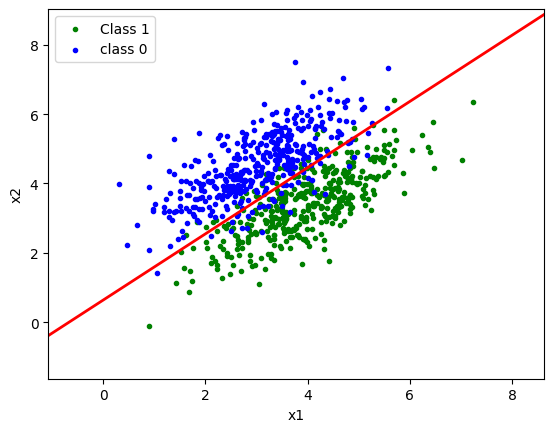

In [69]:
gdaModel.fit(x2_train,y2_train)
plot(x2_train, y2_train, gdaModel.Theta,"ds2_train_gda.png", 1)

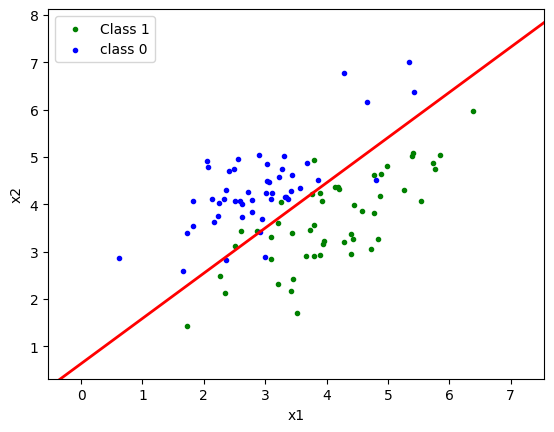

In [70]:
plot(x2v,y2v,gdaModel.Theta,"ds2_prid_gda.png",1)